In [1]:
!pip install -r requirements.txt

In [2]:
!pip install dmol-book --no-deps --force-reinstall

  Using cached dmol_book-1.3.2-py3-none-any.whl.metadata (1.6 kB)
Requested dmol-book from https://files.pythonhosted.org/packages/3e/6a/35eedf410d49ddef8a456b3a47a5057e994cc2fd26a62f53e3770777ef35/dmol_book-1.3.2-py3-none-any.whl has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    ipython (!=8.7.0jax)
            ~~~~~~~~^
Please use pip<24.1 if you need to use this version.
  Using cached dmol_book-1.3.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached dmol_book-1.3.2-py3-none-any.whl.metadata (1.6 kB)
Requested dmol-book from https://files.pythonhosted.org/packages/3e/6a/35eedf410d49ddef8a456b3a47a5057e994cc2fd26a62f53e3770777ef35/dmol_book-1.3.2-py3-none-any.whl has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    ipython (!=8.7.0jax)
            ~~~~~~~~^
Please use pip<24.1 if you need to use this version.
Using cached dmol_book-1.3.1-py3-none-any.whl (2.4 kB)
  Attempt

In [3]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from dataclasses import dataclass
import dmol

In [4]:
df = pd.read_csv('/content/enumerated_smiles.csv')
pd_data = df['Enumerated_SMILES'].tolist()
print("Total data size", len(pd_data))

Total data size 15696


In [5]:
selfies_list = [sf.encoder(s) for s in pd_data]

In [6]:
print(selfies_list[1887])

[C][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][O][C][C][N][Ring1][Branch2][C]


In [7]:
selfies_symbol_counts = {"[nop]": 0}


def parse(s):
    for si in s.split("[")[1:]:
        token = "[" + si
        if token in selfies_symbol_counts:
            selfies_symbol_counts[token] += 1
        else:
            selfies_symbol_counts[token] = 0


[parse(s) for s in selfies_list]

# print out topic tokens
sorted_token_counts = list(sorted(selfies_symbol_counts.items(), key=lambda i: -i[1]))
for p in sorted_token_counts[:10]:
    print(*p)

[C] 149195
[=C] 44543
[Ring1] 36196
[Branch1] 31369
[N] 30173
[O] 24183
[=N] 16445
[=Branch1] 11932
[#Branch1] 6585
[=O] 4812


In [8]:
vocab = list(selfies_symbol_counts.keys())
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}


def selfies2ints(s):
    result = []
    for si in s.split("[")[1:]:
        result.append(vocab_stoi["[" + si])
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies_list[0]
print("selfies:", s)
v = selfies2ints(s)
print("selfies2ints:", v)
so = ints2selfies(v)
print("ints2selfes:", so)
assert so == s

selfies: [C][C][=N][N][=C][Branch1][O][C][S][C][=N][C][=C][C][=N][Ring1][=Branch1][NH1][Ring1][=N]
selfies2ints: [1, 1, 2, 3, 4, 5, 6, 1, 7, 1, 2, 1, 4, 1, 2, 8, 9, 10, 8, 2]
ints2selfes: [C][C][=N][N][=C][Branch1][O][C][S][C][=N][C][=C][C][=N][Ring1][=Branch1][NH1][Ring1][=N]


In [9]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=64,
    buffer_size=10000,
    embedding_dim=256,
    rnn_units=128,
)

In [10]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list]
# Keras pads with 0s - [nop] in our vocab
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))


def split_input_target(sequence):
    # remove last input (since no label exists)
    # prefix with [nop]
    input_text = tf.concat(([0], sequence[:-1]), 0)
    target_text = sequence
    return input_text, target_text

In [11]:
data = seqs_data.map(split_input_target)
data = (
    data.shuffle(config.buffer_size)
    .batch(config.batch_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
# grab examples
for d in data:
    example = d[0]
    example_y = d[1]
    break

In [12]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(
    input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
)(x)
# reset_after - TFJS requires this as false
h = tf.keras.layers.GRU(
    config.rnn_units, return_sequences=True, reset_after=False, stateful=False
)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
train_model = tf.keras.Model(inputs=x, outputs=yhat)

In [13]:
yhat = train_model(example)
train_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │          6,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, None, 128)      │        147,840 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 25)       │          3,225 │ gru[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 157,465 (615.10 KB)

 Trainable params: 157,465 (615.10 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_model.compile(tf.optimizers.Adam(5e-4), loss=loss)


result = train_model.fit(data, epochs=16, verbose=0)

In [16]:
x = tf.keras.Input(shape=(None,), batch_size=1)
ex = tf.keras.layers.Embedding(
    input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
)(x)
h = tf.keras.layers.GRU(
    config.rnn_units, return_sequences=False, reset_after=False, stateful=True
)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
inference_model = tf.keras.Model(inputs=x, outputs=yhat)

# now copy over weights
inference_model.set_weights(train_model.get_weights())

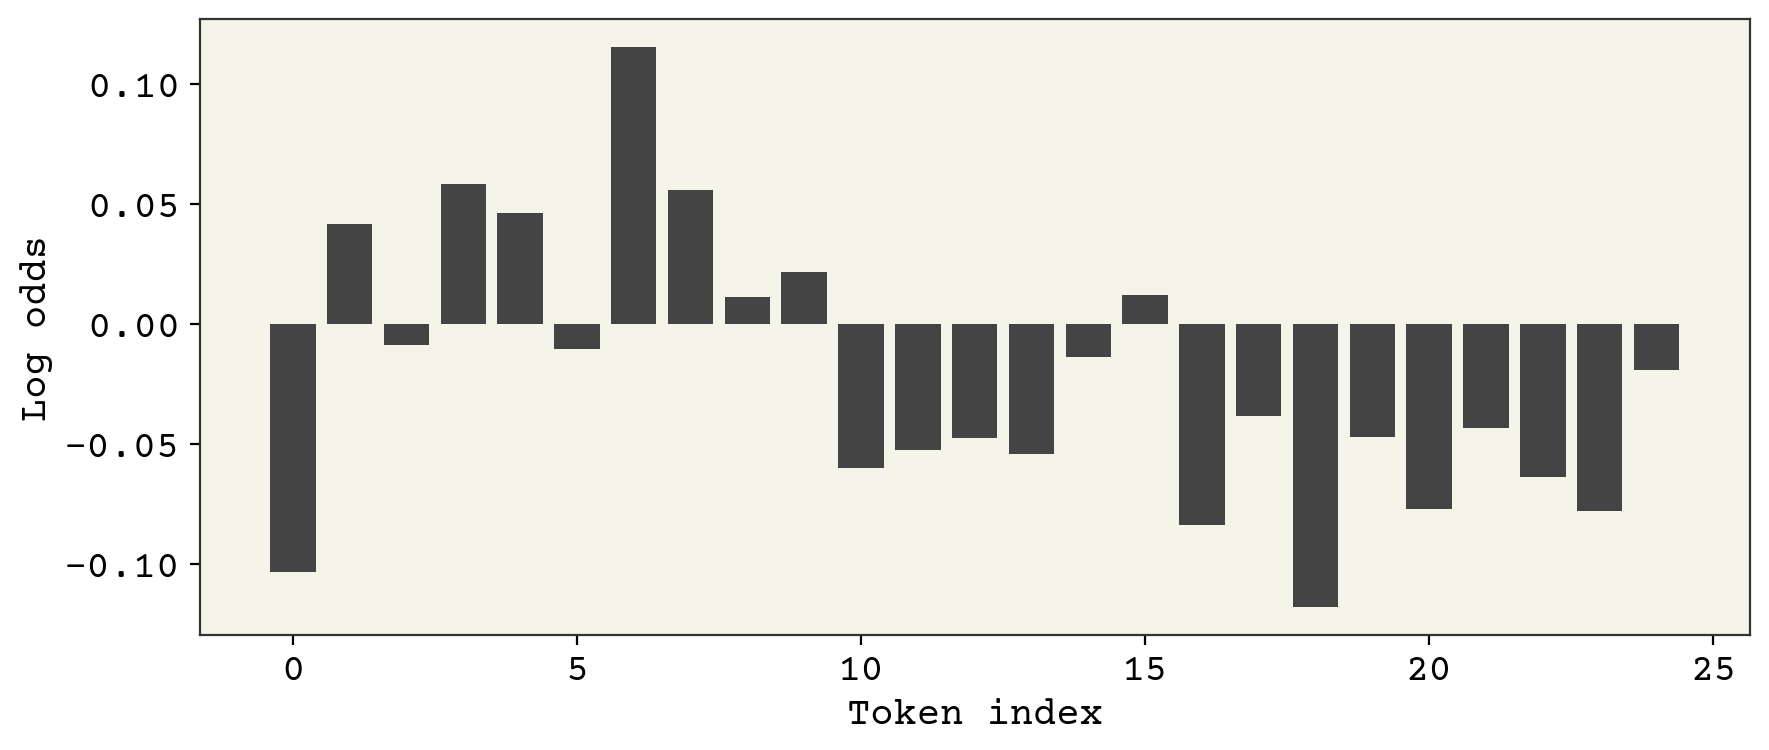

In [17]:
plt.figure(figsize=(10, 4))
x = np.array([0]).reshape(1, 1)
v = inference_model.predict(x, verbose=0)
plt.bar(x=np.arange(config.vocab_size), height=np.squeeze(v))
plt.xlabel("Token index")
plt.ylabel("Log odds")
plt.show()

In [18]:
def sample_token(x, T=1):
    return tf.random.categorical(x / T, 1)


t = sample_token(v)
print(t)

tf.Tensor([[7]], shape=(1, 1), dtype=int64)


In [19]:
def sample_model(T=1):
    length = np.random.randint(1, 100)
    seq = []
    # Start with a NumPy array with the [nop] token
    x = np.array([[0]])

    for _ in range(length):
        v = inference_model.predict(x, verbose=0)
        x = sample_token(v, T)
        # Reshape x to a (1, 1) array for the next prediction
        x = x.numpy().reshape(1, 1)
        seq.append(int(np.squeeze(x)))
    return seq

In [20]:
def draw_examples(model, count=50, save_file="generated_molecules.txt"):
    # Generate and convert molecules
    examples = [ints2selfies(model()) for _ in range(count)]
    examples_smiles = [sf.decoder(s) for s in examples]


    with open(save_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(examples_smiles) + '\n')

    # Molecular visualization
    from rdkit.Chem import rdDepictor
    examples_mols = [rdkit.Chem.MolFromSmiles(s) for s in examples_smiles]

    return rdkit.Chem.Draw.MolsToGridImage(
        examples_mols,
        molsPerRow=3,
        subImgSize=(250, 250),
    )



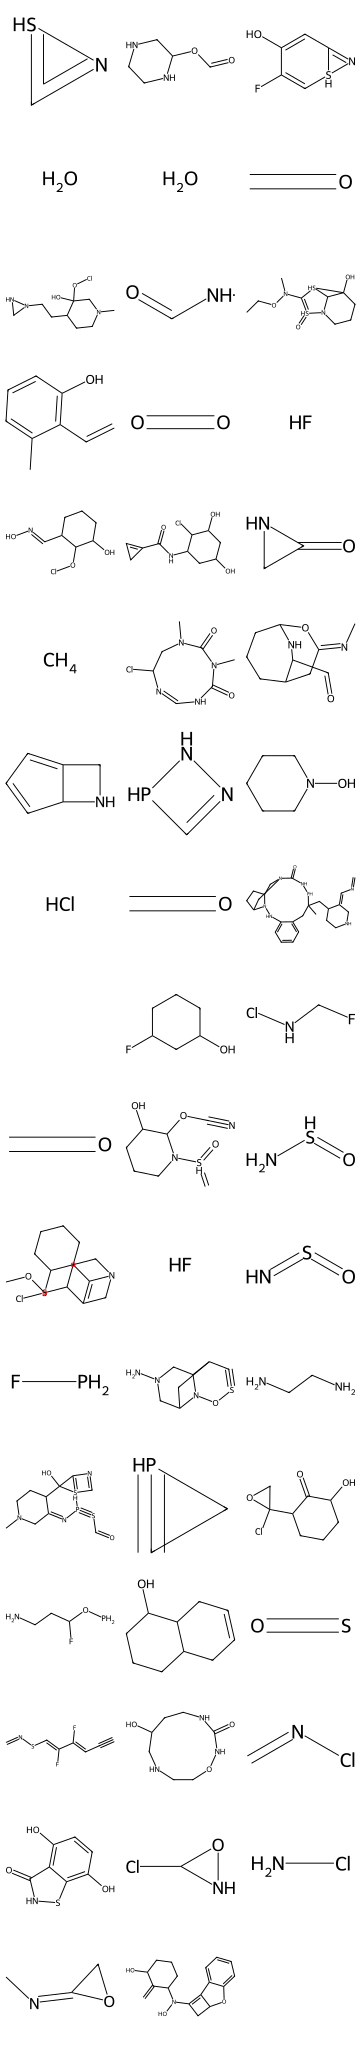

In [22]:
draw_examples(lambda: sample_model(T=0.2))